#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 검증

 **학습 목표:**
  * 단일 특성이 아닌 여러 특성을 사용하여 모델의 효과를 더욱 높인다
  * 모델 입력 데이터의 문제를 디버깅한다
  * 테스트 데이터 세트를 사용하여 모델이 검증 데이터에 과적합되었는지 확인한다

 이전 실습과 동일하게 1990년 인구조사 자료에서 추출한 캘리포니아 주택 데이터 세트를 사용하여 지역별 `median_house_value`를 예측해 보겠습니다.

 ## 설정

 우선 데이터를 로드하고 준비합니다. 이번에는 여러 특성을 다룰 것이므로 특성을 전처리하는 로직을 모듈화하겠습니다.

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

In [ ]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

 **학습 세트**로는 총 17,000개 예 중에서 처음 12,000개를 선택합니다.

In [ ]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [ ]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


 **검증 세트**로는 총 17,000개 예 중에서 마지막 5,000개를 선택합니다.

In [ ]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [ ]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


 ## 작업 1: 데이터 조사
이제 위 데이터를 살펴보겠습니다. 사용 가능한 입력 특성은 `9`개입니다.

값 테이블을 간단히 훑어보세요. 이상한 점이 없나요? 문제점이 몇 가지 발견되는지 세어보세요. 통계학에 대해 문외한이라도 괜찮습니다. 상식 선에서 살펴봐도 충분합니다.

데이터를 직접 살펴보았으면 해결 방법을 확인하여 여러 가지 데이터 검증 방법을 알아보세요.

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

 다음과 같은 최소 기준을 가지고 데이터를 확인할 수 있습니다.

* `median_house_value` 등의 값은 합리적인 범위 내에 들어가는지를 확인할 수 있습니다. 현재가 아닌 1990년 자료임에 주의하세요.

* `latitude`, `longitude` 등의 값은 간단한 Google 검색을 통해 기대값과 부합하는지 간단히 점검할 수 있습니다.

면밀히 살펴보면 몇 가지 이상한 점이 눈에 띕니다.

* `median_income`의 척도는 약 3~15 범위인데, 그 의미가 불분명합니다. 일종의 로그 척도로 보이지만 별도로 설명된 곳이 없으며, 높은 값은 높은 소득에 해당한다는 것만 유추할 수 있습니다.

* `median_house_value`의 최대값은 500,001입니다. 이 값은 인위적인 한도로 보입니다.

* `rooms_per_person` 특성의 척도는 일반적으로 상식에 부합하며, 75번째 백분위수 값이 약 2입니다. 그런데 18이나 55 같은 매우 큰 값이 보이며, 이는 데이터 손상의 증거일 수 있습니다.

지금은 이 특성을 그대로 사용하겠습니다. 이러한 예를 통해 출처가 불분명한 데이터를 검증하는 방법에 대해 감을 익히시기 바랍니다.

 ## 작업 2: 위도/경도와 주택 가격 중앙값을 비교하여 도식화

 **`latitude`**와 **`longitude`**라는 두 가지 특성을 중점적으로 살펴보겠습니다. 이들은 특정 구역의 지리 좌표를 나타냅니다.

이러한 특성은 시각화하기가 좋습니다. `latitude`와 `longitude`를 도식화하고 `median_house_value`를 색상으로 표현해 보겠습니다.

In [ ]:
plt.subplot(4, 1, 1)
plt.subplot(4, 4, 5)
plt.subplot(4, 4, 6)
plt.subplot(4, 4, 7)
plt.subplot(4, 4, 8)
plt.subplot(4, 2, 5)
plt.subplot(4, 4, 11)
plt.subplot(4, 4, 12)
plt.subplot(4, 1, 4)

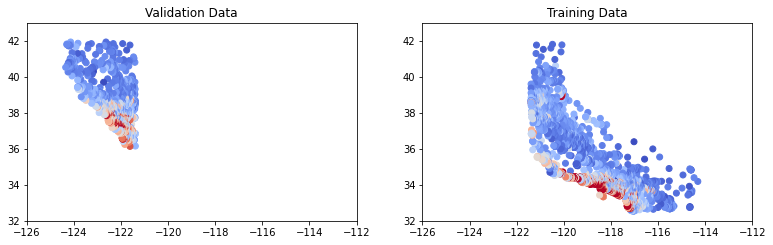

In [ ]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(2, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(2,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

# ax = plt.subplot(2, 1, 2)
# ax.set_title("The Test_1")
# ax.set_ylim([0, 50])
# ax.set_xlim([-5, 5])
# x = range(-5, 5)
# y = x
# plt.bar(x, y)

_ = plt.plot()

 정상적으로 기대되는 결과는 캘리포니아주 지도가 그려지면서 샌프란시스코, 로스앤젤레스 같이 주택 가격이 높은 지역이 빨간색으로 표시되는 것입니다.

[실제 지도](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55)와 비교해 보면 학습 세트는 어느 정도 기대에 부합하지만 검증 세트는 그렇지 못합니다.

**작업 1로 돌아가서 데이터를 다시 살펴보세요.**

학습 데이터와 검증 데이터 사이에서 특성 또는 타겟의 분포에 또 다른 차이점이 보이나요?

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

 위의 요약 통계 테이블을 살펴보면, 유용한 데이터 검증 방법이 있기는 한지 의문스러울 수 있습니다. 특정 지역의 total_rooms에 대한 75<sup></sup>번째 백분위수 값에 정답이 있을까요?

여기에서 알아야 할 점은, 특성 또는 열의 종류에 관계없이 학습 세트와 검증 세트에서 값의 분포가 대략적으로 같아야 한다는 점입니다.

값의 분포가 다르다면 심각한 문제이며, 학습 세트와 검증 세트를 만드는 방법이 잘못되었을 가능성이 높다는 의미입니다.

 ## 작업 3:  데이터 가져오기 및 전처리 코드로 돌아가서 버그가 있는지 확인
버그가 발견되면 바로 수정하세요. 1~2분만 투자하여 간단히 살펴보시기 바랍니다. 버그를 찾지 못한 경우 해결 방법을 참조하세요.

 문제점을 찾아서 수정했으면 위의 `latitude` / `longitude` 도식화 셀을 다시 실행하여 타당성 검사 결과가 좋아졌는지 확인합니다.

여기에서 중요한 교훈을 얻을 수 있습니다.

**ML의 디버깅은 코드 디버깅이 아닌 *데이터 디버깅*인 경우가 많습니다.**

데이터가 잘못되었다면 가장 발전한 최신 ML 코드라도 문제를 일으킬 수밖에 없습니다.

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

 데이터를 읽을 때 무작위로 섞는 부분을 살펴봅니다.

학습 세트와 검증 세트를 만들 때 데이터를 무작위로 적절히 섞지 않으면, 데이터가 일정한 규칙으로 정렬된 경우 문제가 생길 수 있습니다. 바로 이 문제가 발생한 것으로 생각됩니다.

 ## 작업 4: 모델 학습 및 평가

**5분 정도 시간을 내어 초매개변수를 다양하게 설정해 봅니다.  검증 성능을 최대한 높여보세요.**

다음으로, 데이터 세트의 모든 특성을 사용하여 선형 회귀 모델을 학습시키고 성능을 확인합니다.

앞에서 텐서플로우 모델에 데이터를 로드할 때 사용한 것과 동일한 입력 함수를 정의하겠습니다.


In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 이제 여러 입력 특성을 다뤄야 하므로 특성 열을 구성하는 코드를 모듈화하여 별도의 함수로 만들겠습니다. 지금은 모든 특성이 숫자이므로 코드가 비교적 단순하지만, 이후 실습에서 다른 유형의 특성을 사용하면서 이 코드를 확장해 나갈 것입니다.)

In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

 다음으로, 아래의 `train_model()` 코드를 완성하여 입력 함수를 설정하고 예측을 계산합니다.

**참고:** 이전 실습의 코드를 참조해도 무방하지만 적절한 데이터 세트에 대해 `predict()`를 호출해야 합니다.

학습 데이터와 검증 데이터의 손실을 비교합니다. 원시 특성이 하나일 때는 가장 양호한 평균 제곱근 오차(RMSE)가 약 180이었습니다.

이제 여러 특성을 사용하면 얼마나 개선되는지 확인해 보세요.

앞에서 살펴본 몇 가지 방법으로 데이터를 점검하세요.  예를 들면 다음과 같습니다.

   * 예측 값과 실제 타겟 값의 분포 비교

   * 예측 값과 타겟 값으로 산포도 작성

   * `latitude` 및 `longitude`를 사용하여 검증 데이터로 두 개의 산포도 작성
      * 색상을 실제 타겟 `median_house_value`에 매핑하는 도식 작성
      * 색상을 예측된 `median_house_value`에 매핑하는 도식을 작성하여 나란히 비교

In [ ]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = # YOUR CODE HERE
  predict_training_input_fn = # YOUR CODE HERE
  predict_validation_input_fn = # YOUR CODE HERE
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = # YOUR CODE HERE
    validation_predictions = # YOUR CODE HERE
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [ ]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00001,
    steps=100,
    batch_size=1,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

In [ ]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [ ]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 작업 5: 테스트 데이터로 평가

**아래 셀에서 테스트 데이터 세트를 로드하고 이를 기준으로 모델을 평가합니다.**

검증 데이터에 대해 많은 반복을 수행했습니다.  이제 해당 표본의 특이성에 대한 과적합이 발생하지 않았는지 확인해야 합니다.

테스트 세트는 [여기](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv)에 있습니다.

검증 성능과 비교하여 테스트 성능이 어떠한가요?  이 결과가 모델의 일반화 성능에 대해 무엇을 시사하나요?

In [ ]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
#
# YOUR CODE HERE
#

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

In [ ]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)